# Interval Analysis in Makam Music
*Matthew Greenlees and Luis Joglar Ongay*

## Stuff to remember
We take each score, separate it at all the rests, then do $n$-gram counting on all the separated bits. This stops us from getting phrases which have a rest in the middle of them, ie not phrases.
An $n$-gram is a sequence of $n$ notes. We store each $n$-gram as a list of tuples 
$$
\left[(0, (p_0, d_0)), (i_1, (p_1, d_1)), \dots, (i_N, (p_N, d_N))\right]
$$

For each score, we look at all $n$-grams of lengths $n_{\text{min}}$ to $n_{\text{max}}$, and store then as a dictionary
$$
S_i = \left\{ n_{\text{min}}: D_{n_{\text{min}}}, n_{\text{min}} + 1: D_{n_{\text{min}} + 1}, \dots, n_{\text{max}}: D_{n_{\text{max}}}\right\}
$$

where $D_{j}$ is a dictionary containing $n$-grams as keywords whose values are integers representing the number of times they occur. 

For each Makam, we then create a dictionary 
$$
M_i = \left\{     f_{S_1}: S_1, f_{S_2}: S_2,, \dots, f_{S_3}: S_3,     \right\}
$$
of scores $S_i$, where $f_{S_i}$ is the filename of $S_i$. We then use $M_i$ to create a dictionary 
$$
\hat{M}_i = \left\{ n_{\text{min}}: \hat{D}_{n_{\text{min}}}, n_{\text{min}} + 1: \hat{D}_{n_{\text{min}} + 1}, \dots, n_{\text{max}}: \hat{D}_{n_{\text{max}}}\right\}
$$
which allows us to count the number of occurances of each phrase over all the scores in a single Makam. 

Then, we create a master dictionary
$$
\text{DoMNG} = \left\{    m_1:\hat{M}_1, m_2:\hat{M}_2, \dots, m_k:\hat{M}_k    \right\}
$$
where $m_i$ is the name of Makam $i$.



## things to do
- [ ] remove phrases that occur less than 5 times in a makam (or a score?), set a global threshold for it
- [ ] do some plots of some sort
- [ ] only include phrases that appear in at least half of the scores for a given makam
- [ ] if relative intervals don't work, then should work with intervals relative to the tonic

In [2]:
import pandas as pd 
import os
import seaborn as sns

In [3]:
# this is just setting some global variables... both of these are the minimum and maximum n gram sizes...
min_n, max_n = 5, 8

score_threshold = 20

number_of_phrases = 3

In [10]:
def get_path(filename):
    return './SymbTr/txt/' + filename

def add_ngram_dicts(a, b):
    return dict((i, a.get(i, 0) + b.get(i, 0)) for i in set(a) | set(b))

def get_relative_intervals(list_of_tuples):
    """Given a list of tuples representing a phrase, function
    returns a list of tuples of the same size that contains
    the intervals relative to the previous note.
    """
    lt = [(0, list_of_tuples[0][1])]
    for i in range(1, len(list_of_tuples)):
        lt.append((list_of_tuples[i][0] - list_of_tuples[i - 1][0], list_of_tuples[i][1]))
    return lt

def get_ngrams_from_list_of_tuples(list_of_notes, min_n, max_n):
    """Given a list of tuples, function returns all of the n-grams,
    where n ranges from min_n to max_n inclusive.
    """
    len_list = len(list_of_notes)
    
    # Make sure the list is large enough for n-gram analysis, return an empty list otherwise.
    # For illustration, there is no point looking for n-grams of length 5 if your list is only
    # 3 elements long.
    if len_list < min_n:
        return {}
    
    # Take the max_n to be the minimum of the length of the list and the original max_n.
    # For illustration, there is no point looking for an n-gram of length of length 8 if
    # your list is only 5 elements long.
    max_n = min(max_n, len_list)

    d = {}
    for n in range(min_n, max_n + 1):
        # For each n-gram size n, create a dictionary d_n containing all the phrases of length
        # n and number of occurances of each phrase, then add this dictionary to the dictionary
        # d with keyword n.
        d_n = {}
        
        # [HERE] we are ignoring the n-gram above n_max... we should at least put them as zero
        for m in range(0, len_list - n + 1):
            relative_intervals = str(get_relative_intervals(list_of_notes[m : m + n]))
            if relative_intervals in d_n:
                d_n[relative_intervals] += 1
            else:
                d_n[relative_intervals] = 1
        d[n] = d_n
    return d

def get_ngram_dict_from_score(filename, min_n, max_n):
    """Given the filename of a score and the min and max values of n,
    function returns the n-gram dictionary for the score.
    """
    # read in the score as a dataframe
    score = pd.read_csv(get_path(filename), delimiter = '\t')
    data = score[['Payda', 'Pay', 'Koma53']]
    
    # list of sections will return a list of lists containing tuples of the form (koma, (pay, payda)),
    # current list is just a placeholder for the lists that will be added to list_of_sections
    list_of_sections = []
    current_section = []

    for row in data.iterrows():
        koma = row[1]['Koma53']
        pay = row[1]['Pay']
        payda = row[1]['Payda']
        
        # If the note is a rest (koma == -1), and current_section is non-empty, then add current_section to
        # list_of_sections. If not, then continue adding notes to the current_section 
        if koma == -1 and current_section:
            list_of_sections.append(current_section)
            current_section = []
        elif koma == -1:
            continue
        else:
            current_section.append((koma, (pay, payda)))
    
    # If the last case is not empty, then add it to the list of sections. This is just a check as
    # sometimes the last note is a rest.
    if current_section:
        list_of_sections.append(current_section)
    
    # I'm not sure if this code is needed if we fix it.... ctrl-f [HERE]
    ngram_dict = {}
    for i in range(min_n, max_n + 1):
        ngram_dict[i] = {}

    for section in list_of_sections:
        section_dict = get_ngrams_from_list_of_tuples(section, min_n, max_n)
        for n in range(min_n, max_n + 1):
            if n not in section_dict:
                section_dict[n] = {}
            ngram_dict[n] = add_ngram_dicts(ngram_dict[n], section_dict[n])
    
    return ngram_dict

def get_dict_of_makam_dicts(makam_scores_dict, min_n, max_n):
    """Takes dictionary of makam scores and returns a dictionary
    containing the n-grams for each score of each makam.
    """
    dict_of_makam_dicts = {}

    for makam_name in makam_scores_dict:
        d = {}
        for filename in makam_scores_dict[makam_name]:
            d[filename] = get_ngram_dict_from_score(filename, min_n, max_n)
        dict_of_makam_dicts[makam_name] = d
    return dict_of_makam_dicts  
    
def get_dict_of_makam_ngrams(dict_of_makam_dicts, min_n, max_n):
    """Takes a dictionary containing dictionaries of makam dictionaries and
    returns a dictionary containing the summed n-grams for each makam.
    """
    dict_of_makam_ngrams = {}

    for makam_name in dict_of_makam_dicts:
        d = {}
        for i in range(min_n, max_n + 1):
            d[i] = {}
        for score in dict_of_makam_dicts[makam_name]:
            s = dict_of_makam_dicts[makam_name][score]
            for i in range(min_n, max_n + 1):
                d[i] = add_ngram_dicts(d[i], s[i])
        dict_of_makam_ngrams[makam_name] = d
    return dict_of_makam_ngrams

def flatten_ngram(ngram):
    """Takes and n-gram dictionary and flattens it so that all of the phrases are on the same level.
    """
    flat_ngram = {}
    for n in ngram:
        flat_ngram = {**flat_ngram, **ngram[n]}
    return flat_ngram

def most_common_phrases(flat_ngram, n):
    """Given a flat n-gram and an integer n, it finds the n most common phrases in the n-gram.
    """
    temp_ngram = flat_ngram
    most_common_phrases = []
    for i in range(n):
        phrase = max(temp_ngram, key = temp_ngram.get)
        most_common_phrases.append( (phrase, temp_ngram[phrase])  )
        del temp_ngram[phrase]
    return most_common_phrases

def get_set_of_most_common_phrases(number_of_phrases):
    """Takes an integer number_of_phrases and returns a set containing the most common phrases
    in our dictionary of all makam n-grams.
    """
    set_of_most_common_phrases = set()

    for makam in dict_of_makam_ngrams:
        k = flatten_ngram(dict_of_makam_ngrams[makam])
        m = most_common_phrases(k, number_of_phrases)
        for p in m:
            set_of_most_common_phrases.add(p[0])
    return set_of_most_common_phrases

def get_most_common_phrases_in_makams(dict_of_makam_ngrams, set_of_most_common_phrases):
    """Takes as input the set of most common phrases in each of the n-grams, and the dictionary
    of n-grams from each makam, and then returns a dictionary of dictionaries, where each dictionary
    represents a makam, and within these sub-dictionaries contains the number of occurences of each
    phrase in that makam.
    """
    most_common_phrases_in_makams = {}
    for makam in dict_of_makam_ngrams: 
        temp_phrases = {}
        temp_flattened_ngram = flatten_ngram(dict_of_makam_ngrams[makam])
        for phrase in set_of_most_common_phrases:
            if phrase in temp_flattened_ngram:
                temp_phrases[phrase] = temp_flattened_ngram[phrase]
            else:
                temp_phrases[phrase] = 0
        most_common_phrases_in_makams[makam] = temp_phrases
    return most_common_phrases_in_makams

In [11]:
# create a list of the filenames
filenames = [fn for _, _, fn in os.walk('./SymbTr/txt')][0]

# count the number of scores belonging to each makam and store in a dictionary number_of_makam
number_of_makam = {}

for filename in filenames:
    makam = filename.split('--')[0]
    if makam in number_of_makam:
        number_of_makam[makam] += 1
    else:
        number_of_makam[makam] = 1

# creates a dictionary of the names of the makams that have more than 20 (threshold) scores
makams_above_threshold = {makam: number for makam, number in number_of_makam.items() if number >= score_threshold}

# this just prints the makams who have more than 20 tracks (or whatever the threshold is set to)
for makam, number in makams_above_threshold.items():
    print(makam, number)

rast 110
ussak 119
acemasiran 63
kurdilihicazkar 70
nihavent 128
saba 67
hicazkar 79
beyati 62
evic 33
segah 93
muhayyer 67
suzidil 20
hicaz 160
muhayyerkurdi 32
suzinak 43
huseyni 91
buselik 57
hisarbuselik 20
mahur 88
acemkurdi 37
sehnaz 25
gerdaniye 25
nikriz 25
huzzam 96
sultaniyegah 22
yegah 22
hicaz-humayun 34
neva 22
isfahan 22
nisaburek 25
karcigar 53
tahir 31


In [12]:
#makams_to_analyse = {'rast', 'ussak', 'nihavent', 'hicaz'}
#makams_to_analyse = {'karcigar', 'saba', 'muhayyer', 'beyati'}
makams_to_analyse = {'evic', 'neva', 'tahir', 'yegah'}

makam_scores_dict = {}

# This is creating a list of dictionary whose keywords are the makam names, and whose values are a dictionary
# of the filenames of the scores in that makam.
for makam in makams_to_analyse:
    filenames_from_makam = [filename for filename in filenames if filename.split('--')[0] == makam]
    makam_scores_dict[makam] = filenames_from_makam

In [13]:
dict_of_makam_dicts = get_dict_of_makam_dicts(makam_scores_dict, min_n, max_n) 
dict_of_makam_ngrams = get_dict_of_makam_ngrams(dict_of_makam_dicts, min_n, max_n)
set_of_most_common_phrases = get_set_of_most_common_phrases(number_of_phrases)
most_common_phrases_in_makams = get_most_common_phrases_in_makams(dict_of_makam_ngrams, set_of_most_common_phrases)

In [14]:
for makam in most_common_phrases_in_makams:
    print(makam)
    for phrase in most_common_phrases_in_makams[makam]:
        print(phrase, most_common_phrases_in_makams[makam][phrase])
    print('\n')

tahir
[(0, (1, 8)), (-5, (1, 16)), (-8, (1, 16)), (0, (1, 16)), (-9, (1, 16))] 0
[(0, (1, 16)), (0, (1, 16)), (-9, (1, 16)), (0, (1, 16)), (-5, (1, 16))] 2
[(0, (1, 16)), (-6, (1, 16)), (6, (1, 16)), (-6, (1, 16)), (0, (1, 16)), (-7, (1, 16))] 44
[(0, (1, 8)), (-8, (1, 8)), (8, (1, 8)), (5, (1, 8)), (-5, (1, 8))] 0
[(0, (1, 8)), (8, (1, 8)), (5, (1, 8)), (-5, (1, 8)), (-8, (1, 8))] 0
[(0, (1, 16)), (8, (1, 16)), (-8, (1, 16)), (-9, (1, 16)), (-5, (1, 16))] 0
[(0, (1, 16)), (6, (1, 16)), (-6, (1, 16)), (0, (1, 16)), (-7, (1, 16))] 44
[(0, (1, 8)), (-8, (1, 8)), (8, (1, 8)), (5, (1, 8)), (-5, (1, 8)), (-8, (1, 8))] 0
[(0, (1, 16)), (9, (1, 16)), (-9, (1, 16)), (-9, (1, 16)), (-6, (1, 16))] 0
[(0, (1, 8)), (-9, (1, 8)), (-9, (1, 8)), (-6, (1, 8)), (-7, (1, 8))] 5
[(0, (1, 8)), (-9, (1, 8)), (-6, (1, 8)), (-7, (1, 8)), (-9, (1, 8))] 10
[(0, (1, 16)), (-6, (1, 16)), (6, (1, 16)), (-6, (1, 16)), (0, (1, 16))] 46


neva
[(0, (1, 8)), (-5, (1, 16)), (-8, (1, 16)), (0, (1, 16)), (-9, (1, 16))] 

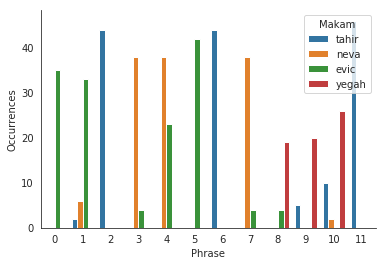

In [15]:
# create a dataframe that we will use to create a bar plot
columns = ['Phrase', 'Makam', 'Occurrences']
indices = range(len(set_of_most_common_phrases) * len(most_common_phrases_in_makams))
dataframe = pd.DataFrame(index = indices, columns = columns)



# this is just for graphing it nicer
phrase_short_names = dict(zip(set_of_most_common_phrases, range(len(set_of_most_common_phrases))))

# count position in dataframe
counter = 0
for makam in most_common_phrases_in_makams:
    for phrase in most_common_phrases_in_makams[makam]:
        dataframe.loc[indices[counter], 'Makam'] = makam
        dataframe.loc[indices[counter], 'Phrase'] = phrase_short_names[phrase]
        dataframe.loc[indices[counter], 'Occurrences'] = most_common_phrases_in_makams[makam][phrase]
        counter += 1

sns.set_style('white')
ax = sns.barplot(x = "Phrase",
                 y = "Occurrences",
                 hue = "Makam",
                 data = dataframe)
sns.despine()

fig = ax.get_figure()
fig.savefig('makam.png')